# Introductory applied machine learning (INFR10069) 

# Lab 3: Decision trees and linear regression

In the first part of this lab we perform Decision trees classification on the [German credit](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) data set. In the second part we learn how to train simple linear regression model by using the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) data set. Both datasets (`credit.csv` and `cpu.csv`) are located at the `./datasets` directory which is adjacent to this file.

First, let's import the packages we will be using throughout this lab:

In [38]:
# Import packages
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
%matplotlib inline

## 1. Decision Trees
One of the great advantages of decision trees is their interpretability. The rules learnt for classification are easy for a person to follow, unlike the opaque "black box" of many other methods, such as neural networks. We demonstrate the utility of this using a German credit data set. You can read a description of this dataset at the [UCI site](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29). The task is to predict whether a loan approval is good or bad credit risk based on 20 attributes. We've simplified the data set somewhat, particularly making attribute names and values more meaningful.

Download the dataset and save it in a directory called `datasets` in the same folder that your notebooks live. Alternatively, you can save the dataset in any folder you wish and modify the `data_path` variable below accordingly. We will load our data into a pandas DataFrame structure. 

In [39]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'credit.csv')
credit = pd.read_csv(data_path, delimiter = ',')

### ========== Question 1.1 ==========
Display the number of data points and attributes in the dataset. 

In [40]:
# Your code goes here
print('Number of samples: {}, number of attributes: {}'.format(credit.shape[0], credit.shape[1]))

Number of samples: 1001, number of attributes: 21


### ========== Question 1.2 ==========
Get a feeling of the data by using pandas `describe()` method. 

In [41]:
# Your code goes here
credit.describe(include=[np.number])

,Duration,CreditAmount,InstallmentRate,ResidentSince,Age,NumCreditsAtBank,Dependents
count,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,20.882118,-9.957330e+05,-7.019980,2.842158,35.217782,0.406593,0.969031
std,12.070878,3.160708e+07,316.165715,1.106825,15.398264,31.656714,5.894916
min,0.000000,-1.000000e+09,-10000.000000,0.000000,-293.000000,-1000.000000,-185.000000
25%,12.000000,1.364000e+03,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2.319000e+03,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3.972000e+03,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,1.842400e+04,4.000000,4.000000,75.000000,4.000000,2.000000


In [42]:
credit.describe(include=['O'])

,CheckingAccount,CreditHistory,Purpose,SavingsAccount,YearsEmployed,PersonalStatus,OtherDebtors,Property,OtherPlans,Housing,Job,Telephone,Foreign,Approve
count,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001
unique,4,5,10,5,5,5,3,4,3,3,4,2,2,2
top,none,ok_til_now,television,<100,<4,male_single,none,car,none,own,skilled,no,yes,good
freq,394,530,280,603,339,548,908,333,815,714,631,596,963,701


### ========== Question 1.3 ==========
Display the first 10 data points of the dataset

In [43]:
# Your code goes here
pd.set_option('display.max_columns', None)
credit.head(10)

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,ResidentSince,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
0,<0,0.0,ok,furniture,-1.000000e+09,unknown,unemployed,-10000.0,female_single,none,0.0,car,-293.0,none,own,-1000.0,skilled,-185.0,yes,no,good
1,<0,6.0,critical,television,1.169000e+03,unknown,>=7,4.0,male_single,none,4.0,real_estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
2,<200,48.0,ok_til_now,television,5.951000e+03,<100,<4,2.0,female,none,2.0,real_estate,22.0,none,own,1.0,skilled,1.0,no,yes,bad
3,none,12.0,critical,education,2.096000e+03,<100,<7,2.0,male_single,none,3.0,real_estate,49.0,none,own,1.0,unskilled,2.0,no,yes,good
4,<0,42.0,ok_til_now,furniture,7.882000e+03,<100,<7,2.0,male_single,guarantor,4.0,savings,45.0,none,free,1.0,skilled,2.0,no,yes,good
5,<0,24.0,past_delays,car_new,4.870000e+03,<100,<4,3.0,male_single,none,4.0,unknown,53.0,none,free,2.0,skilled,2.0,no,yes,bad
6,none,36.0,ok_til_now,education,9.055000e+03,unknown,<4,2.0,male_single,none,4.0,unknown,35.0,none,free,1.0,unskilled,2.0,yes,yes,good
7,none,24.0,ok_til_now,furniture,2.835000e+03,<1000,>=7,3.0,male_single,none,4.0,savings,53.0,none,own,1.0,skilled,1.0,no,yes,good
8,<200,36.0,ok_til_now,car_used,6.948000e+03,<100,<4,2.0,male_single,none,2.0,car,35.0,none,rent,1.0,management,1.0,yes,yes,good
9,none,12.0,ok_til_now,television,3.059000e+03,>=1000,<7,2.0,male_divorced,none,4.0,real_estate,61.0,none,own,1.0,unskilled,1.0,no,yes,good


In [44]:
pd.set_option('display.max_columns', 0)

### ========== Question 1.4 ==========
When presented with a dataset, it is usually a good idea to visualise it first. By using seaborn's [pairplot](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function, try visualising a scatter plot of the `Age` and `Duration` variables. You can use the `Approve` variable as the `hue` parameter to visualise results separately for each class. Do you notice anything unusual?

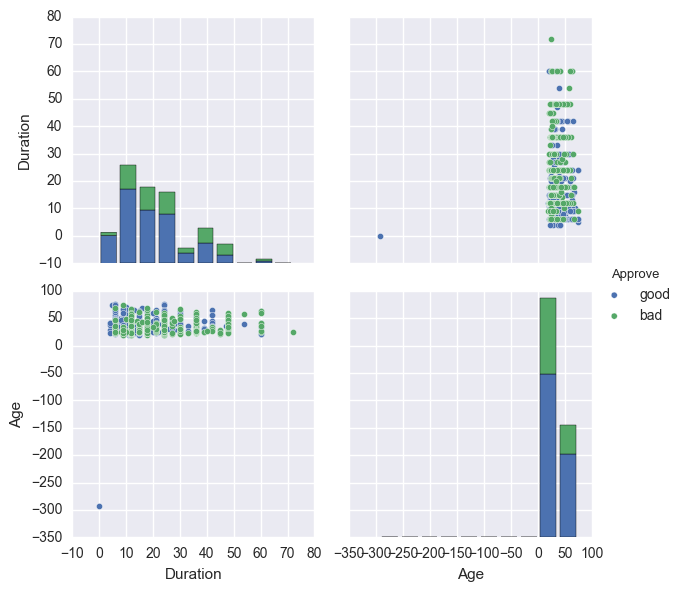

In [45]:
# Your code goes here
g = sns.pairplot(data=credit, vars=['Duration', 'Age'], hue='Approve', size=3)

*Your answer goes here*

There is a data point with negative age. This doesn't make sense whatsoever and this data point has been clearly corrupted with noise.

### ========== Question 1.5 ==========
In the previous point you should have found a data point, which seems to be corrupted, as some of its values are nonsensical. Even a single point like this can significantly affect the performance of a classifier. How do you think it would affect Decision trees? How about Naive Bayes? A good way to check this is to test the performance of each classifier before and after removing this datapoint.

*Your answer goes here*

Naive Bayes fits Gaussian distributions and thus is very sensitive to outliers. Decision trees is expected to be less affected.

### ========== Question 1.6 ==========
Now we want to remove this instance from the dataset by using a filter. We want to remove all instances, where the age of an applicant is lower than 0 years, as this suggests that the instance is corrupted. Use logical indexing to get rid of these instances without creating a new dataframe. Display the number of data points after any outliers have been removed.

In [46]:
# Your code goes here
credit = credit[credit['Age']>0]
print('Number of data points after removal of outliers: {}'.format(credit.shape[0]))

Number of data points after removal of outliers: 1000


### ========== Question 1.7 ==========

You might have noticed that most of the attributes in the dataset are in fact discrete. Now we want to know which variables exactly are discrete (both categorical and numerical, look [here](http://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data) if you are unsure about the difference) and which are continuous variables. In order to do so, we will inspect the number of possible values that each attribute can take. 

Display the number of values each attributes takes in the dataset. *Hint: As a first step, you want to loop over the columns of the DataFrame. Then you might find the numpy `unique` function quite useful.*

In [47]:
# Your code goes here
for column in credit:
    unique_vals = np.unique(credit[column])
    nr_vals = len(unique_vals)
    if nr_vals < 11:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals)) 

Number of values for attribute CheckingAccount: 4 -- ['<0' '<200' '>=200' 'none']
Number of values for attribute Duration: 33
Number of values for attribute CreditHistory: 5 -- ['critical' 'ok' 'ok_at_this_bank' 'ok_til_now' 'past_delays']
Number of values for attribute Purpose: 10 -- ['appliances' 'business' 'car_new' 'car_used' 'education' 'furniture'
 'others' 'repairs' 'retraining' 'television']
Number of values for attribute CreditAmount: 921
Number of values for attribute SavingsAccount: 5 -- ['<100' '<1000' '<500' '>=1000' 'unknown']
Number of values for attribute YearsEmployed: 5 -- ['<1' '<4' '<7' '>=7' 'unemployed']
Number of values for attribute InstallmentRate: 4 -- [ 1.  2.  3.  4.]
Number of values for attribute PersonalStatus: 4 -- ['female' 'male_divorced' 'male_married' 'male_single']
Number of values for attribute OtherDebtors: 3 -- ['co' 'guarantor' 'none']
Number of values for attribute ResidentSince: 4 -- [ 1.  2.  3.  4.]
Number of values for attribute Property: 4

It seems like the variables `Duration`, `CreditAmount` and `Age` are continuous and all the rest are discrete. The discrete variables are not in a very convenient format though. Ideally we would want the discrete attributes to take values between `0` and `n_values-1`. Scikit-learn has a handy [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) implementation which can do that for us. You are encouraged to read its documentation.

Now we will create a new DataFrame called `credit_clean` and convert all the discrete variables from `credit` by using a `LabelEncoder`. Remember, we want to change the discrete variables only, so we will have to exclude the `CreditAmount`, `Age` and `Duration` attributes. Also, we don't really mind if the target variable is categorical, so we won't be transforming the `Approve` attribute either. Execute the cell below and make sure you understand what it does.

In [48]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
credit_clean = credit.copy(deep=True) # Make a copy of the DataFrame
# Loop over attributes by excluding the ones that are continuous and the target variable
for column in credit_clean.drop(['CreditAmount', 'Age', 'Duration', 'Approve'], axis=1):  
    le = LabelEncoder().fit(credit[column]) # Initialise the LabelEncoder and fit
    credit_clean[column] = le.transform(credit[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

### ========== Question 1.8 ==========
Display the first 10 data points of the clean data. Does it look like what you expected?

In [49]:
# Your code goes here
credit_clean.head(10)

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,ResidentSince,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
1,0,6.0,0,9,1169.0,4,3,3,3,2,3,1,67.0,1,1,1,1,0,1,1,good
2,1,48.0,3,9,5951.0,0,1,1,0,2,1,1,22.0,1,1,0,1,0,0,1,bad
3,3,12.0,0,4,2096.0,0,2,1,3,2,2,1,49.0,1,1,0,3,1,0,1,good
4,0,42.0,3,5,7882.0,0,2,1,3,1,3,2,45.0,1,0,0,1,1,0,1,good
5,0,24.0,4,2,4870.0,0,1,2,3,2,3,3,53.0,1,0,1,1,1,0,1,bad
6,3,36.0,3,4,9055.0,4,1,1,3,2,3,3,35.0,1,0,0,3,1,1,1,good
7,3,24.0,3,5,2835.0,1,3,2,3,2,3,2,53.0,1,1,0,1,0,0,1,good
8,1,36.0,3,3,6948.0,0,1,1,3,2,1,0,35.0,1,2,0,0,0,1,1,good
9,3,12.0,3,9,3059.0,3,2,1,1,2,3,1,61.0,1,1,0,3,0,0,1,good
10,1,30.0,0,2,5234.0,0,4,3,2,2,1,0,28.0,1,1,1,0,0,0,1,bad


### ========== Question 1.9 ==========
Store the input features (i.e. attributes) into a matrix `X` and the target variable (`Approve`) into a vector `y`. Remember to not include the target variable into `X`. *Hint: You can either use pandas `as_matrix()` or `values`.* 

Display the shapes of `X` and `y`. Confirm that you have 20 input features, one target variable and 1000 data points.

In [50]:
# Your code goes here
X = credit_clean.drop('Approve', axis=1).as_matrix() # Input features (attributes)
y = credit_clean['Approve'].as_matrix() # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (1000, 20)
y shape: (1000,)


## Hold-out validation
In the next step we will be using a Decision Tree classifier model. To get an accurate estimate of the model's classification performance we will use hold-out validation. Familiriase yourself with the logic behind [`train_test_split CV`](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) (also called `Hold-out` validation) and [how it is used](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) in `Scikit-learn`. Execute the cell below to create your training/testing sets by assigning 10% of the data to the test set (and convince yourself you understand what is going on).

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

### ========== Question 1.10 ==========
Confirm that `X_train` and `X_test` matrices are subsets of `X` by displaying the number of rows in the three matrices (no need to make use of set theory).

In [52]:
# Your code goes here
print('Number of instances in X: {}'.format(np.shape(X)[0]))
print('Number of instances in X_train: {}'.format(X_train.shape[0]))
print('Number of instances in X_test: {}'.format(X_test.shape[0]))
print('Number of instances in X_train and X_test together: {}'.format(X_train.shape[0] + X_test.shape[0]))

Number of instances in X: 1000
Number of instances in X_train: 900
Number of instances in X_test: 100
Number of instances in X_train and X_test together: 1000


### ========== Question 1.11 ==========
Now we will train a Decision Tree classifier on the training data. Read about [Decision Tree classifiers](http://scikit-learn.org/stable/modules/tree.html) in `Scikit-learn` and how they are [used](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). 
Create a `DecisionTreeClassifier` instance and train it by using training data only (i.e. `X_train` and `y_tain`). Set the `criterion` attribute to `entropy` in order to measure the quality of splits by using the information gain. Use the default settings for the rest of parameters. By default, trees are grown to full depth; this means that very fine splits are made involving very few data points. Not only does this make the trees hard to visualise (they'll be deep), but also we could be overfitting the data. For now, we arbitrarily choose a depth of 2 for our tree, but this is a parameter we could tune.

In [53]:
# Your code goes here
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1337)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

We have mentioned in the class that decision trees have the advantage of being interpretable by humans. Now we visualise the decision tree we have just trained. Scikit-learn can export the tree in a `.dot` format. To visualise the tree, open the output .dot file with an editor, copy its content and paste into [this online .dot renderer](http://dreampuf.github.io/GraphvizOnline/) (you can double click on the tree once it has been produced to view it in full screen).

In [54]:
from sklearn import tree
from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
    f = export_graphviz(dt, out_file=f,
                        feature_names=credit_clean.drop('Approve', axis=1).columns,  
                        class_names=credit_clean['Approve'].unique(),  
                        filled=True, rounded=True,  
                        special_characters=True)

### ========== Question 1.12 ==========
Inspect the tree. Describe what it shows. Which attribute yields the highest information gain and what is its critical value?

*Your answer goes here*

Below is a png of the tree produced. It shows that we will classify a loan as `bad` if the `CheckingAccount in (2, 3)` i.e. is '>=200' or 'none', and even worse if `OtherPlans in (1, 2)` i.e. is 'none' or 'stores'.

The attribute with highest information gain is the one at the top of the tree - `CheckingAccount`. Its critical value is 1.5. To trace back the original values we have to make use of the associated LabelEncoder.

In [55]:
print(le_dict['CheckingAccount'].classes_)

['<0' '<200' '>=200' 'none']


The critical value for the `CheckingAccount` attribute is thus <200.

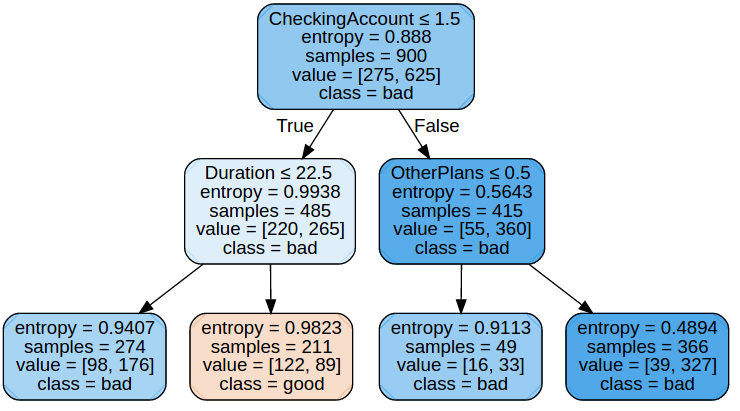

In [56]:
from IPython.display import Image
Image(filename='tree.png') 

N.B. You should query the validity of this tree. The categories here are being treated as numeric, i.e. ordinal. Is 'none' really greater than '>=200' in the `CheckingAccount` attribute...no not really! This is a drawback of the CART method implemented by scikit learn. One way to force the tree to think of these categories as separate is to use a `OnehotEncoder` but, in practice, because the tree can separate the classes it needs by using multiple splitting conditions, this isn't usually a problem. An example of where it is a problem would be if an important condition was if `CheckingAccount` was  '<0' or 'none'. This tree **can't** make a single branch that contains this condition - if you used a `OnehotEncoder` it could.

### ========== Question 1.13 ==========
Tree-based estimators (i.e. decision trees and random forests) can be used to compute feature importances. The importance of a feature is computed as the (normalized) total reduction of entropy (or other used `criterion`) brought by that feature. Find the relevant attribute of the classifier you just trained and display feature importances along with their names.

In [57]:
# Your code goes here
for i, column in enumerate(credit_clean.drop('Approve', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

Importance of feature CheckingAccount:, 0.752
Importance of feature Duration:, 0.154
Importance of feature CreditHistory:, 0.000
Importance of feature Purpose:, 0.000
Importance of feature CreditAmount:, 0.000
Importance of feature SavingsAccount:, 0.000
Importance of feature YearsEmployed:, 0.000
Importance of feature InstallmentRate:, 0.000
Importance of feature PersonalStatus:, 0.000
Importance of feature OtherDebtors:, 0.000
Importance of feature ResidentSince:, 0.000
Importance of feature Property:, 0.000
Importance of feature Age:, 0.000
Importance of feature OtherPlans:, 0.094
Importance of feature Housing:, 0.000
Importance of feature NumCreditsAtBank:, 0.000
Importance of feature Job:, 0.000
Importance of feature Dependents:, 0.000
Importance of feature Telephone:, 0.000
Importance of feature Foreign:, 0.000


### ========== Question 1.14 ==========
Now we want to evaluate the performance of the classifier on unseen data. Use the trained model to predict the target variables for the test data set. Display the classification accuracy for both the training and test data sets. What do you observe? Are you surprised by the results?

In [58]:
# Your code goes here
prediction_train = dt.predict(X=X_train)
prediction_test = dt.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))

Classification accuracy on training set: 0.731
Classification accuracy on test set: 0.730


*Your answer goes here*

The decision tree classifier is not overfitting. The classification accuracy is similar for training and test. The decision tree has provided a very simple way to interpret the data - splitting it into 4 bins and applying a class to each bin. Clearly this is an oversimplification: even in the training data, the leaves of the tree contain many examples of the 'incorrect' class.

**However, the very astute will make an observation:**

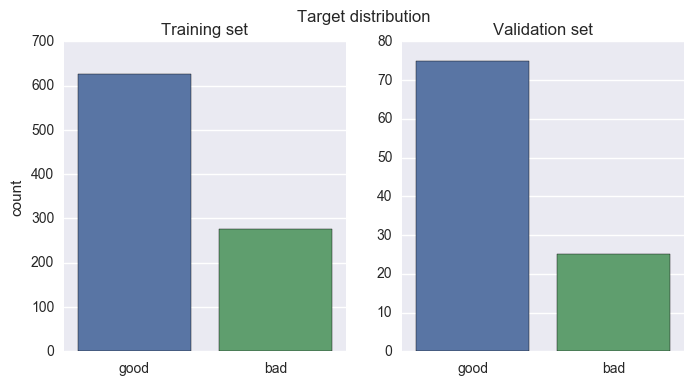

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sns.countplot(y_train, ax=ax1)
ax1.set_title('Training set', size=12)
ax1.set_xlabel(' ')
sns.countplot(y_test, ax=ax2)
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_title('Validation set', size=12)
fig.suptitle('Target distribution', size=12)
plt.show()

The dummy classifier of predicting everything as 'good' **will beat this model (75% accuracy)!** It is worse than the baseline.

### ========== Question 1.15 ==========

Fit another `DecisionTreeClassifier` but this time grow it to full depth (i.e. remove the max_depth condition. Display the classification accuracy for training and test data as above. Again, what do you observe and are you surprised?

In [60]:
dt_fulldepth = DecisionTreeClassifier(criterion='entropy', random_state=1337)
dt_fulldepth.fit(X_train, y_train)
prediction_train2 = dt_fulldepth.predict(X=X_train)
prediction_test2 = dt_fulldepth.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train2)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test2)))

Classification accuracy on training set: 1.000
Classification accuracy on test set: 0.660


*Your answer goes here*

This is a classic case of overfitting. The tree is allowed to grow to full depth and perfectly fit the training data. The result is that the test accuracy is much lower than the train; in fact it is less accurate than the very simple depth 2 tree! It's important to note that, when grown to full depth, decision tree classifiers can perfectly separate the training data (if no two datapoints are identical but have different classes). Performance on unseen data is likely to be much lower.

### ========== Question 1.16 ==========
By using seaborn's heatmap function, plot the normalised confusion matrices for both the training and test data sets **for the max_depth=2 decision tree from question 1.11**. Make sure you label axes appropriately. *Hint: You can make use of the `plot_confusion_matrix` function introduced in Lab_2.*

In [61]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

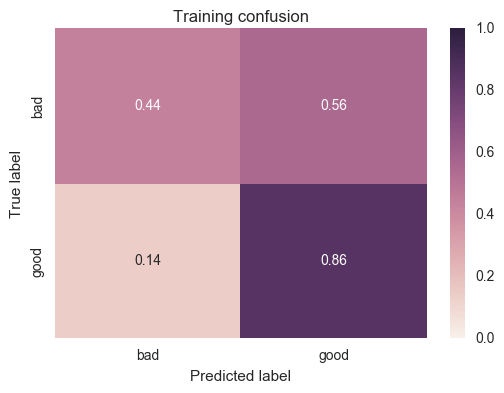

In [62]:
cm = confusion_matrix(y_train, prediction_train)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

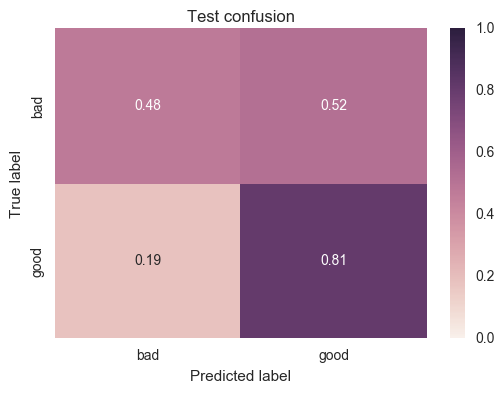

In [63]:
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Test confusion')

**N.B. it will be obvious if you have plotted the full depth decision tree as the training confusion matrix with be the identity**

### ========== Question 1.17 ==========

Finally we will create a [`Random decision forest`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier and compare the performance of this classifier to that of the decision tree. The random decision forest is an ensemble classifier that consists of many decision trees and outputs the class that is the mode of the class's output by individual trees. Start with `n_estimators = 100`, use the `entropy` criterion and the same train/test split as before. Plot the classification accuracy of the random forest model on the test set and show the confusion matrix. How does the random decision forest compare performance wise to the decision tree?

Classification accuracy on test set: 0.780


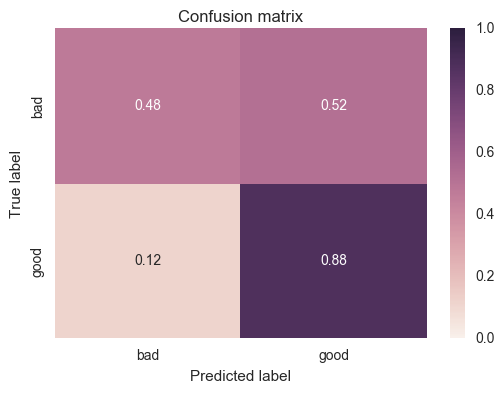

In [64]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

### ========== Question 1.18 ==========
How high can you get the performance of the classifier by changing the max depth of the trees (`max_depth`), or the `max_features` parameters? Try a few values just to get a look. *Don't do a grid search or anything in-depth, just get a feel*. Try the same settings twice...do you get the same accuracy?

Classification accuracy on test set with max features = 1 and max_depth = None: 0.770
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.750
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.750
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.780
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.760
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.750
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.770
Classification accuracy on test set with max features = sqrt and max_depth = 10: 0.750
Classification accuracy on test set with max features = log2 and max_depth = None: 0.760
Classification accuracy on test set with max features = log2 and max_depth = 2: 0.750
Classification accuracy on test set with max features = log2 and max_depth = 5: 0.770
Classification accuracy on test set with max features =

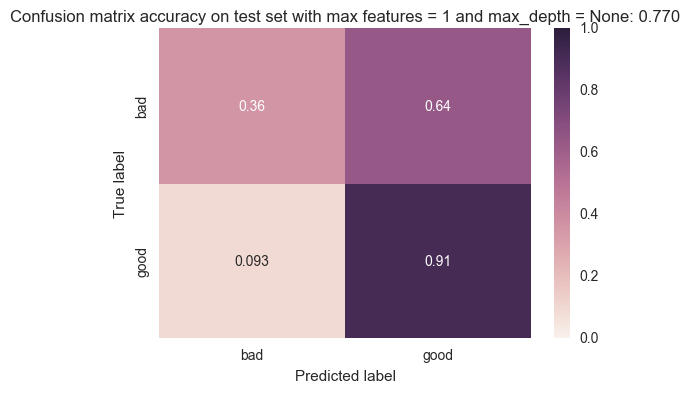

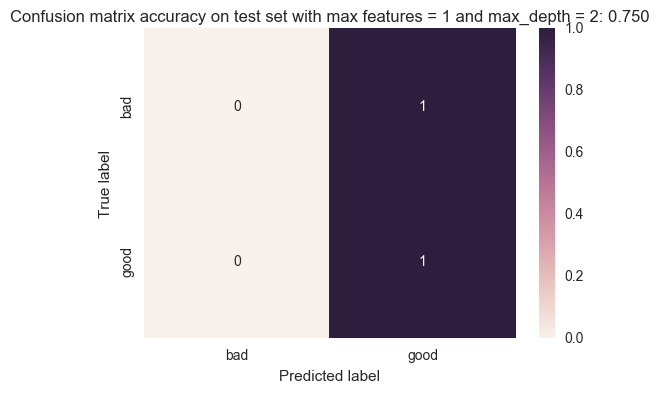

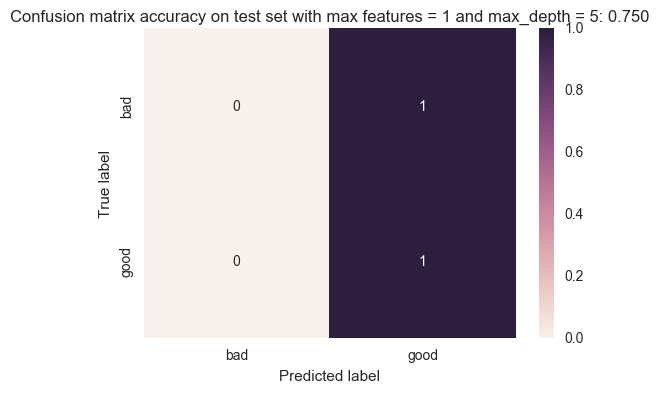

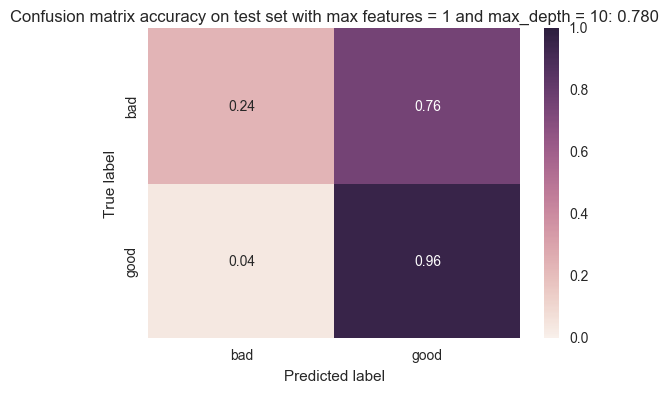

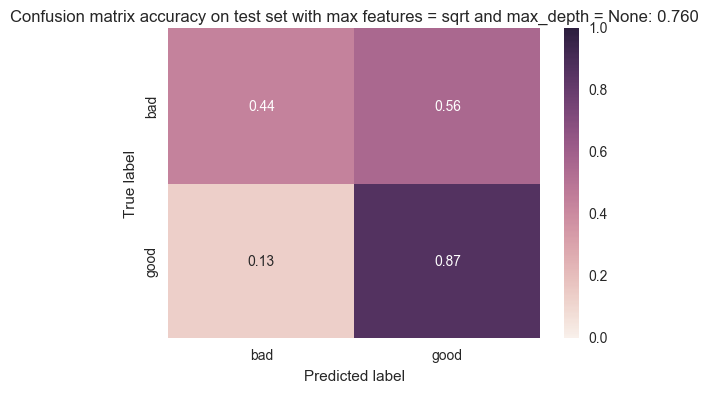

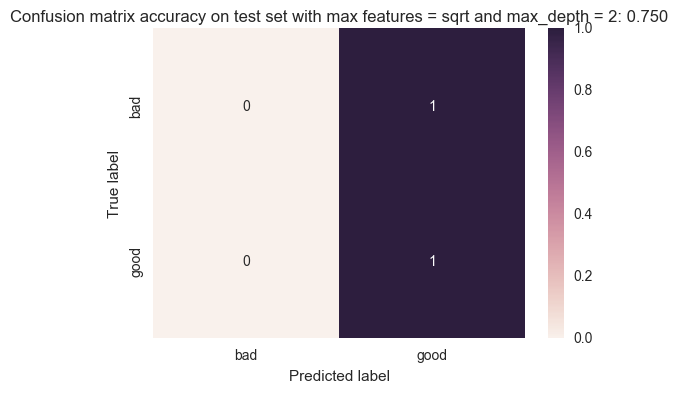

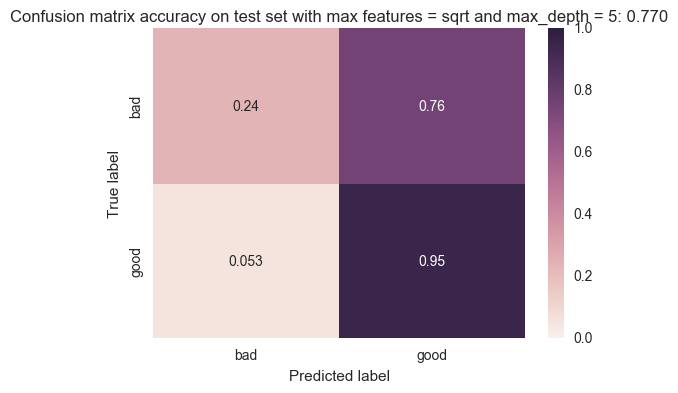

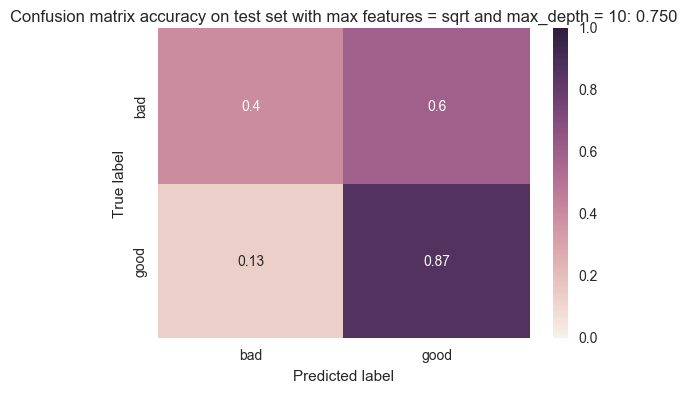

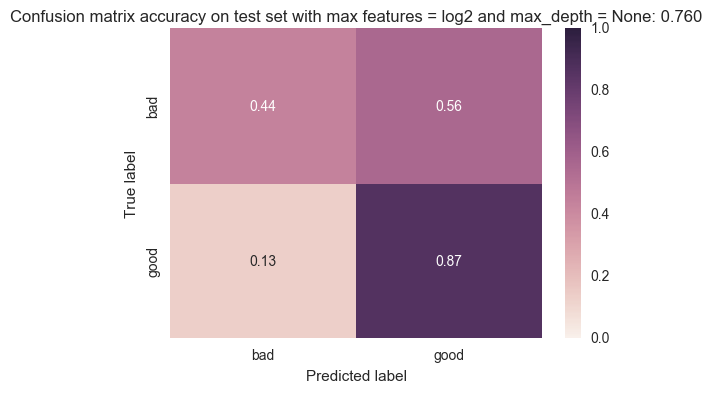

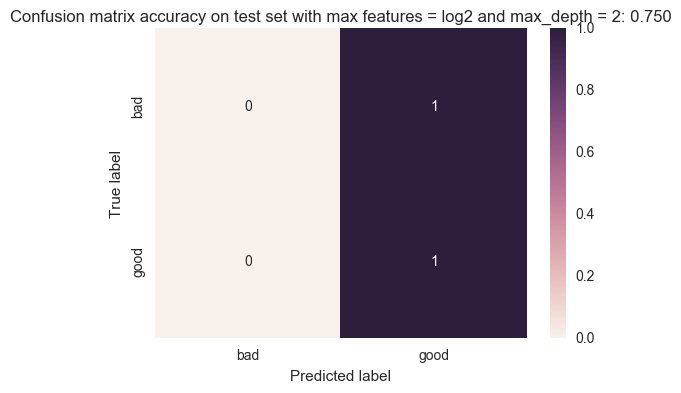

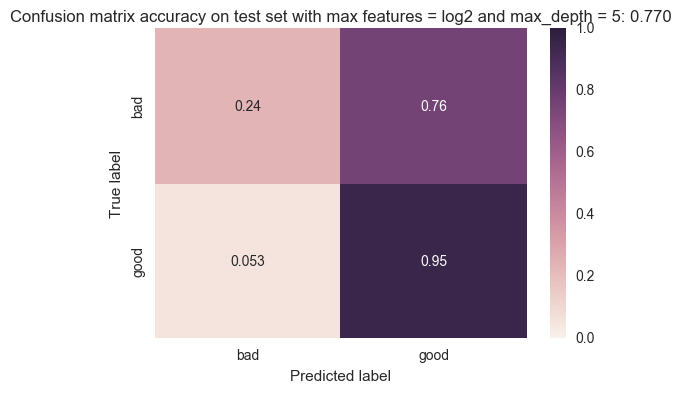

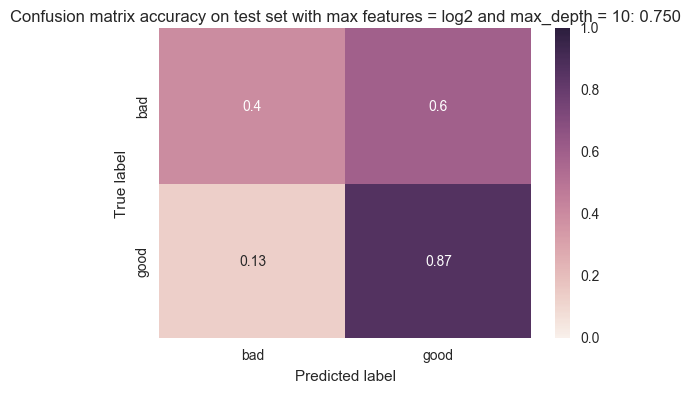

In [65]:
# Your code goes here
from itertools import product
n_estimators = 500
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 5, 10]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

N.B. Observing these confusion matrices you'll see something very important - for some configurations, the Random Forest **always predicts the majority class**. This highlights (again) the importance of always checking performance against a dummy classifier!!!

Additionally, if you want to reproduce your results, you must set the random seed (you can do this with the `random_state` argument). Random forests are...random!

### ========== Question 1.19 ==========
Compare the feature importances as estimated with the decision tree and random forest classifiers.

Importance of feature CheckingAccount, DT: 0.752, RF: 0.110
Importance of feature Duration, DT: 0.154, RF: 0.093
Importance of feature CreditHistory, DT: 0.000, RF: 0.055
Importance of feature Purpose, DT: 0.000, RF: 0.062
Importance of feature CreditAmount, DT: 0.000, RF: 0.104
Importance of feature SavingsAccount, DT: 0.000, RF: 0.057
Importance of feature YearsEmployed, DT: 0.000, RF: 0.055
Importance of feature InstallmentRate, DT: 0.000, RF: 0.045
Importance of feature PersonalStatus, DT: 0.000, RF: 0.035
Importance of feature OtherDebtors, DT: 0.000, RF: 0.022
Importance of feature ResidentSince, DT: 0.000, RF: 0.041
Importance of feature Property, DT: 0.000, RF: 0.049
Importance of feature Age, DT: 0.000, RF: 0.092
Importance of feature OtherPlans, DT: 0.094, RF: 0.033
Importance of feature Housing, DT: 0.000, RF: 0.036
Importance of feature NumCreditsAtBank, DT: 0.000, RF: 0.028
Importance of feature Job, DT: 0.000, RF: 0.035
Importance of feature Dependents, DT: 0.000, RF: 0.0

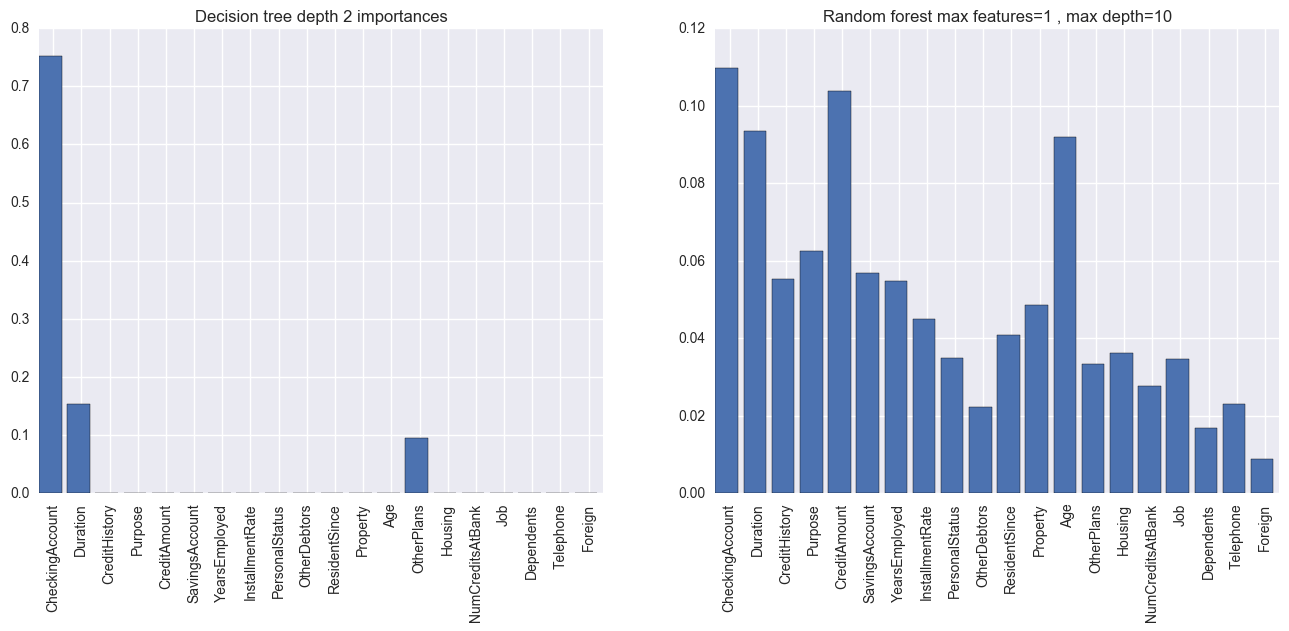

In [66]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=500, 
                            criterion='entropy', 
                            max_features=1, 
                            max_depth=10, 
                            n_jobs=2)
rf.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
xx = np.arange(len(dt.feature_importances_))
ax1.bar(xx, dt.feature_importances_)
ax1.set_xticks(xx + .5)
ax1.set_xticklabels(credit_clean.drop('Approve', axis=1).columns, rotation='vertical')
ax1.set_title('Decision tree depth 2 importances')
ax2.bar(xx, rf.feature_importances_)
ax2.set_xticks(xx + .5)
ax2.set_xticklabels(credit_clean.drop('Approve', axis=1).columns, rotation='vertical')
ax2.set_title('Random forest max features=1 , max depth=10')

for i, column in enumerate(credit_clean.drop('Approve', axis=1)):
    print('Importance of feature {}, DT: {:.3f}, RF: {:.3f}'.format(column, dt.feature_importances_[i], rf.feature_importances_[i]))

## 2. Linear regression
In the second part of the lab we use the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) dataset for a simple regression task. Famliarise yourself with the dataset before moving on to the next step. Note that the version we will be using is missing the `Model Name` and `PRP` attributes. Our task will be to use the remaining attributes to predict `ERP` values.

Download the dataset and save it in a directory called `datasets` in the same folder that your notebooks live. Alternatively, you can save the dataset in any folder you wish and modify the `data_path` variable below accordingly. We will load our data into a pandas DataFrame structure. 

In [67]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'cpu.csv')
cpu = pd.read_csv(data_path, delimiter = ',')

### ========== Question 2.1 ==========
Display the number of data points and attributes in the dataset. 

In [68]:
# Your code goes here
print('Number of samples: {}, number of attributes: {}'.format(cpu.shape[0], cpu.shape[1]))

Number of samples: 209, number of attributes: 8


### ========== Question 2.2 ==========
Get a feeling of the data by using pandas `describe()` method. 

In [69]:
# Your code goes here
cpu.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1238.000000


### ========== Question 2.3 ==========
Display the first 10 data points of the dataset

In [70]:
# Your code goes here
cpu.head(10)

,vendor,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
0,adviser,125.0,256.0,6000.0,256.0,16.0,128.0,199.0
1,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
2,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
3,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
4,amdahl,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0
5,amdahl,26.0,8000.0,32000.0,64.0,8.0,32.0,290.0
6,amdahl,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
7,amdahl,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
8,amdahl,23.0,16000.0,64000.0,64.0,16.0,32.0,749.0
9,amdahl,23.0,32000.0,64000.0,128.0,32.0,64.0,1238.0


### ========== Question 2.4 ========== 
You might have noticed that the `vendor` attribute is categorical. This will give problems when using a linear regression model. For now we can simply remove this attribute. Create a new DataFrame called `cpu_clean` by copying `cpu` but omit the `vendor` attribute. Display the number of samples and attributes in the clean dataset as a sanity check.

In [71]:
# Your code goes here
cpu_clean = cpu.copy(deep=True)
cpu_clean=cpu_clean.drop('vendor', axis=1)
print('Clean dataset, number of samples: {}, number of attributes: {}'.format(cpu_clean.shape[0], cpu_clean.shape[1]))

Clean dataset, number of samples: 209, number of attributes: 7


### ========== Question 2.5 ==========
Now -as always- we want to perform some exploratory data analysis. Remember that our task is to predict `ERP` values, so it's a good idea to inspect individual scatter plots of the target variable (`ERP`) against our input features. For this purpose we will use once again seaborn's pairplot implementation.

Create a series of [pairplots](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) showing the pairwise relationship of `ERP` and the remaining attributes in the data. You can do so by specifying explicitly the `x_vars` and `y_vars` input arguments in the pairplot. *Hnt: Your final plot will consist of 6 subplots each contaning a scatter plot.*

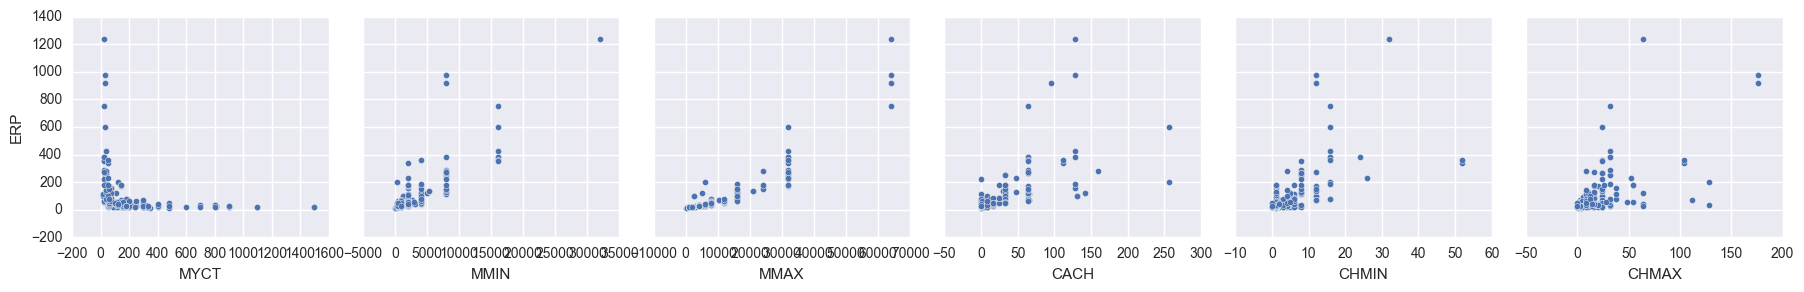

In [72]:
# Your code goes here
g2 = sns.pairplot(data=cpu, x_vars=['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'], y_vars = 'ERP', size=3)

### ========== Question 2.6 ==========
* Do you think that ERP should be at least partially predictable from the input attributes?
* Do any attributes exhibit significant correlations?

*Your answer goes here*

Yes, it seems that some input features are positively correlated with the target variable so it should be possible to partially predict it. The `MMIN` and `MMAX` features appear to exhibit the strongest correlations.

### ========== Question 2.7 ==========
Now we have a feel for the data and we will try fitting a simple linear regression model. Similarly to what we did in the first part of the lab, we want to use cross-validation to evaluate the goodness of the fit.

By using the `cpu_clean` dataset extract the raw values for the input features and the target variable and store them in two matrices, called `X` and `y` respectively. 

Then, split the dataset into training and testing sets by using a 75%-25% split (training/testing).

Display the shapes of all matrices involved and double-check that all dimensionalities appear to be as expected.

In [77]:
# Your code goes here
X = cpu_clean.drop('ERP', axis=1).as_matrix()
y = cpu_clean['ERP'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

print('Number of instances in X: {}'.format(np.shape(X)[0]))
print('Number of instances in X_train: {}'.format(X_train.shape[0]))
print('Number of instances in X_test: {}'.format(X_test.shape[0]))
print('Number of instances in X_train and X_test together: {}'.format(X_train.shape[0] + X_test.shape[0]))

Number of instances in X: 209
Number of instances in X_train: 156
Number of instances in X_test: 53
Number of instances in X_train and X_test together: 209


### ========== Question 2.8 ==========
Fit a simple linear regressor by using the [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model in Scikit-learn. Report the training accuracy by using the `score` attribute. What does this represent?

In [78]:
# Your code goes here
lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
lm.fit(X_train, y_train)
print('Training accuracy: {:.3f}'.format(lm.score(X_train, y_train)))

Training accuracy: 0.916


*Your answer here*

The accuracy score represents the coefficient of determination ($R^2$). This is at max 1, but can be negative. It will be 0 if you predict the mean of y for all observations.

### ========== Question 2.9 ==========
Now report the testing accuracy by using the `score` attribute of the regressor as well as the `r2_score` metric. Confirm that these two yield identical results.

How does the accuracy compare to the one reported on the training dataset? Do you think that your model does well on generalising on unseen data? 

In [79]:
# Your code goes here
print('Testing accuracy by using score function: {:.3f}'.format(lm.score(X_test, y_test)))
print('Testing accuracy by using r2_score meric: {:.3f}'.format(r2_score(y_test, lm.predict(X_test))))

Testing accuracy by using score function: 0.857
Testing accuracy by using r2_score meric: 0.857


*Your answer goes here*

The accuracy on the test dataset is very similar to the training accuracy. From that we can conclude that the model has not overfitted the training data.

### ========== Question 2.10 ==========
Now we want to get a feel for how good the fit is, so we wil plot the measured values against the predicted ones. Make use of the function provided below which takes as input arguments the measured (`y_true`) and predicted (`y_pred`) values of a target variable and produces a scatter plot for the two by also including a straight line going through the origin. 

Where would you expect the circles to be for a perfect fit?

In [80]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

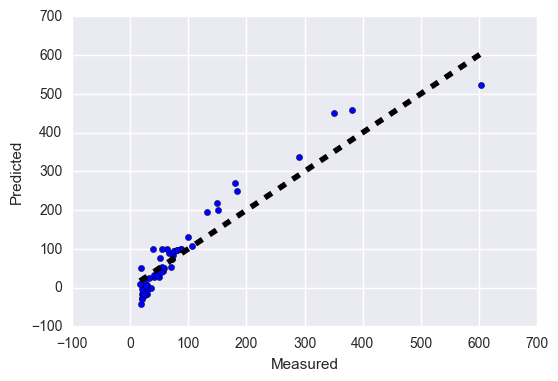

In [81]:
# Your code goes here
prediction = lm.predict(X_test)
fit_scatter(y_test, prediction)

*Your answer goes here*

If the fit was perfect all the points would be sitting on the straight line going through the origin.

### ========== Question 2.11 ==========
Another way of assessing the performance of the model is to inspect the distribution of the errors. Make a histogram plot by using seaborn's `displot` function. This will also show an estimate of the underlying distribution.

Does it look like the errors are normally distributed? Would you trust the fit of the distribution on the graph? Explain why.

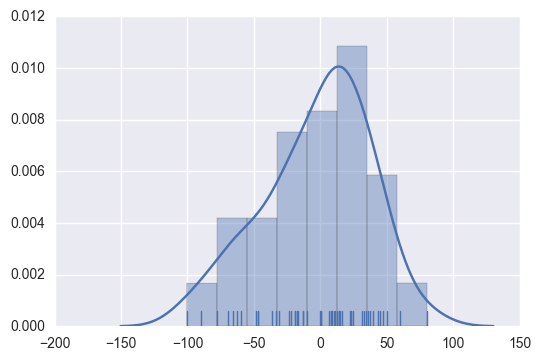

In [82]:
# Your code goes here
g = sns.distplot(y_test-prediction, rug=True)

*Your answer goes here*

Indeed it seems that the errors follow a Gaussian (normal) distribution, however we should be very careful before making any judgements since the number of samples is relatively small in this case.

### ========== Question 2.12 ==========
Above we deleted the vendor variable. However, we can use nominal attributes in regression by converting them to numeric, exactly in the same way that we did at the first part of this lab. 

Now, use the original `cpu` dataset and convert the `vendor` attribute to numeric by using a `LabelEncoder`. Then train a linear regression model to the data and compare its performance to the one we had previously. Did adding the *binazired vendor* variable help? 

In [83]:
# Your code goes here
vendor_le = LabelEncoder()
vendor_le.fit(cpu["vendor"])
cpu["vendor"] = vendor_le.transform(cpu["vendor"])
X = cpu.drop('ERP', axis=1).as_matrix()
y = cpu['ERP'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=0)
lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True).fit(X_train,y_train)
prediction_new = lm.predict(X_test)
print('New accuracy on test set: {:.3f}'.format(lm.score(X_test,y_test)))
print(vendor_le.classes_)

New accuracy on test set: 0.887
['adviser' 'amdahl' 'apollo' 'basf' 'bti' 'burroughs' 'c.r.d' 'cambex'
 'cdc' 'dec' 'dg' 'formation' 'four-phase' 'gould' 'harris' 'honeywell'
 'hp' 'ibm' 'ipl' 'magnuson' 'microdata' 'nas' 'ncr' 'nixdorf'
 'perkin-elmer' 'prime' 'siemens' 'sperry' 'sratus' 'wang']


*Your answer goes here*

Adding the binarized vendor variable only helped a little bit. This was somehow expected, since we made additional use of a discrete variable to predict a continuous one.